In [ ]:
%%bash
pip install tensorflow==2.14
pip install tensorflow-probability==0.22
pip install tensorflow-compression~=2.14

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 95.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 41.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 78.7 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.15.0
    Uninstalling tensorflow-estimator-2.15.0:
      Successfully uninstalled tensorflow-estimator-2.15.0
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
  Attempting uninstall: google-auth-oauthlib
    Found existing installation: google-auth-oauthlib 1.2.0
    Uninstalling google-auth-oauthlib-1.2.0:
      Successfully uninstalled google-auth-oauthlib-1.2.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling te

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.14.0 which is incompatible.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.2.1+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.2.1+cu121 requires nvidia-cuda-runtime-cu12==12.1.105; platform_system == "Linux" and platform_machine ==

In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_compression as tfc
import tensorflow_datasets as tfds

In [ ]:
def make_analysis_transform(latent_dims):
  """Creates the analysis (encoder) transform."""

  return tf.keras.Sequential([
    tf.keras.layers.Conv2D(20, 5, use_bias=True, strides=2, padding="same",
      activation="leaky_relu", name="conv_1"),
    tf.keras.layers.Conv2D(50, 5, use_bias=True, strides=2, padding="same",
      activation="leaky_relu", name="conv_2"),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, use_bias=True, activation="leaky_relu", name="fc_1"),
    tf.keras.layers.Dense(latent_dims, use_bias=True, activation=None, name="fc_2"),
  ], name="analysis_transform")

def make_synthesis_transform():
  """Creates the synthesis (decoder) transform."""

  return tf.keras.Sequential([
    tf.keras.layers.Dense(500, use_bias=True, activation="leaky_relu", name="fc_1"),
    tf.keras.layers.Dense(2450, use_bias=True, activation="leaky_relu", name="fc_2"),
    tf.keras.layers.Reshape((7, 7, 50)),
    tf.keras.layers.Conv2DTranspose(20, 5, use_bias=True, strides=2, padding="same",
      activation="leaky_relu", name="conv_1"),
    tf.keras.layers.Conv2DTranspose(1, 5, use_bias=True, strides=2, padding="same",
      activation="leaky_relu", name="conv_2"),
  ], name="synthesis_transform")

In [ ]:
class MNISTCompressionTrainer(tf.keras.Model):
  """Model that trains a compressor/decompressor for MNIST."""

  def __init__(self, latent_dims):
    super().__init__()
    self.analysis_transform = make_analysis_transform(latent_dims)
    self.synthesis_transform = make_synthesis_transform()
    self.prior_log_scales = tf.Variable(tf.zeros((latent_dims,)))

  @property
  def prior(self):
    return tfc.NoisyLogistic(loc=0., scale=tf.exp(self.prior_log_scales))

  def call(self, x, training):
    """Computes rate and distortion losses."""

    # Ensure inputs are floats in the range (0,1).
    x = tf.cast(x, self.compute_dtype) / 255
    x = tf.reshape(x, (-1, 28, 28, 1))

    # Compute latent space representation y, perturb it and model its entropy,
    # then compute the reconstructed pixel-level representation x_hat.
    y = self.analysis_transform(x)
    entropy_model = tfc.ContinuousBatchedEntropyModel(self.prior, coding_rank=1, compression=False)
    y_tilde, rate = entropy_model(y, training=training)
    x_tilde = self.synthesis_transform(y_tilde)

    # Average number of bits per MNIST digit.
    rate = tf.reduce_mean(rate)

    # Mean absolute difference across pixels.
    distortion = tf.reduce_mean(abs(x- x_tilde))

    return dict(rate=rate, distortion=distortion)

In [ ]:
training_dataset, validation_dataset = tfds.load(
  "mnist",
  split=["train", "test"],
  shuffle_files=True,
  as_supervised=True,
  with_info=False,
)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# 获取训练数据集的大小
training_size = tf.data.experimental.cardinality(training_dataset).numpy()

# 获取验证数据集的大小
validation_size = tf.data.experimental.cardinality(validation_dataset).numpy()

print("Training size:", training_size)
print("Validation size:", validation_size)


Training size: 60000
Validation size: 10000


Data type: <dtype: 'uint8'>
Shape: (28, 28, 1)


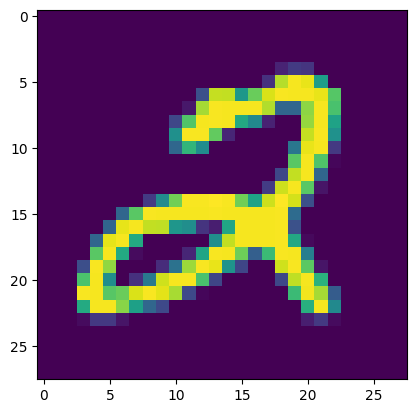

In [ ]:
(x, _), = validation_dataset.take(1)
plt.imshow(tf.squeeze(x))
print(f"Data type: {x.dtype}")
print(f"Shape: {x.shape}")

In [ ]:
x = tf.cast(x, tf.float32) / 255.
x = tf.reshape(x, (-1, 28, 28, 1))
y = make_analysis_transform(10)(x)

In [ ]:
y_tilde = y + tf.random.uniform(y.shape, -.5, .5)

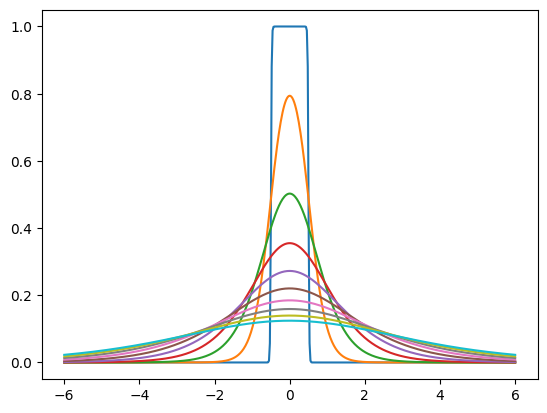

In [ ]:
prior = tfc.NoisyLogistic(loc=0., scale=tf.linspace(.01, 2., 10))
_ = tf.linspace(-6., 6., 501)[:, None]
plt.plot(_, prior.prob(_));

In [ ]:
entropy_model = tfc.ContinuousBatchedEntropyModel(prior, coding_rank=1, compression=False)

y_tilde, rate = entropy_model(y, training=True)
print(rate)

tf.Tensor([18.598513], shape=(1,), dtype=float32)


distortion: tf.Tensor(0.17088045, shape=(), dtype=float32)
Data type: <dtype: 'uint8'>
Shape: (28, 28, 1)


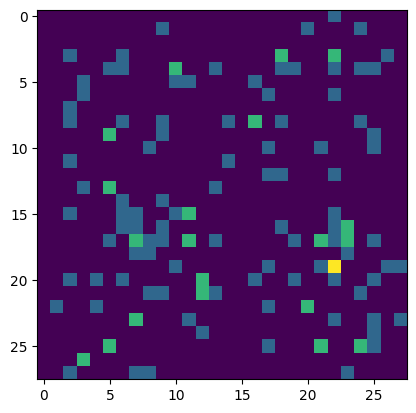

In [ ]:
x_tilde = make_synthesis_transform()(y_tilde)

# Mean absolute difference across pixels.
distortion = tf.reduce_mean(abs(x- x_tilde))
print("distortion:", distortion)

x_tilde = tf.saturate_cast(x_tilde[0] * 255, tf.uint8)
plt.imshow(tf.squeeze(x_tilde))
print(f"Data type: {x_tilde.dtype}")
print(f"Shape: {x_tilde.shape}")

In [ ]:
(example_batch, _), = validation_dataset.batch(32).take(1)
trainer = MNISTCompressionTrainer(10)
example_output = trainer(example_batch)

print("rate: ", example_output["rate"])
print("distortion: ", example_output["distortion"])

rate:  tf.Tensor(20.296253, shape=(), dtype=float32)
distortion:  tf.Tensor(0.14659302, shape=(), dtype=float32)


In [ ]:
def pass_through_loss(_, x):
  # Since rate and distortion are unsupervised, the loss doesn't need a target.
  return x

def make_mnist_compression_trainer(lmbda, latent_dims=50):
  trainer = MNISTCompressionTrainer(latent_dims)
  trainer.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),

    # Just pass through rate and distortion as losses/metrics.
    loss=dict(rate=pass_through_loss, distortion=pass_through_loss),
    metrics=dict(rate=pass_through_loss, distortion=pass_through_loss),
    loss_weights=dict(rate=1., distortion=lmbda),
  )
  return trainer

In [ ]:
def add_rd_targets(image, label):
  # Training is unsupervised, so labels aren't necessary here. However, we
  # need to add "dummy" targets for rate and distortion.
  return image, dict(rate=0., distortion=0.)

def train_mnist_model(lmbda):
  trainer = make_mnist_compression_trainer(lmbda)
  trainer.fit(
    training_dataset.map(add_rd_targets).batch(128).prefetch(8),
    epochs=15,
    validation_data=validation_dataset.map(add_rd_targets).batch(128).cache(),
    validation_freq=1,
    verbose=1,
  )
  return trainer

In [ ]:
trainer = train_mnist_model(lmbda=2000)

Epoch 1/15
467/469 [============================>.] - ETA: 0s - loss: 218.3340 - distortion_loss: 0.0592 - rate_loss: 99.9309 - distortion_pass_through_loss: 0.0592 - rate_pass_through_loss: 99.9309

469/469 [==============================] - 17s 29ms/step - loss: 218.1726 - distortion_loss: 0.0591 - rate_loss: 99.9004 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 99.8960 - val_loss: 177.6460 - val_distortion_loss: 0.0428 - val_rate_loss: 92.1028 - val_distortion_pass_through_loss: 0.0428 - val_rate_pass_through_loss: 92.1197
Epoch 2/15
469/469 [==============================] - 12s 25ms/step - loss: 166.4989 - distortion_loss: 0.0412 - rate_loss: 84.1796 - distortion_pass_through_loss: 0.0412 - rate_pass_through_loss: 84.1751 - val_loss: 155.9254 - val_distortion_loss: 0.0398 - val_rate_loss: 76.3033 - val_distortion_pass_through_loss: 0.0398 - val_rate_pass_through_loss: 76.3201
Epoch 3/15
469/469 [==============================] - 12s 25ms/step - loss: 151.1494 - distortion_loss: 0.0399 - rate_loss: 71.3811 - distortion_pass_through_loss: 0.0399 - rate_pass_through_loss: 71.3776 - val_loss: 145.4265 - val_distortion_loss: 0.0408 - val_rate_loss: 63.9077 - val_

KeyboardInterrupt: 

In [ ]:
class MNISTCompressor(tf.keras.Model):
  """Compresses MNIST images to strings."""

  def __init__(self, analysis_transform, entropy_model):
    super().__init__()
    self.analysis_transform = analysis_transform
    self.entropy_model = entropy_model

  def call(self, x):
    # Ensure inputs are floats in the range (0, 1).
    x = tf.cast(x, self.compute_dtype) / 255.
    y = self.analysis_transform(x)
    # Also return the exact information content of each digit.
    _, bits = self.entropy_model(y, training=False)
    return self.entropy_model.compress(y), bits

In [ ]:
class MNISTDecompressor(tf.keras.Model):
  """Decompresses MNIST images from strings."""

  def __init__(self, entropy_model, synthesis_transform):
    super().__init__()
    self.entropy_model = entropy_model
    self.synthesis_transform = synthesis_transform

  def call(self, string):
    y_hat = self.entropy_model.decompress(string, ())
    x_hat = self.synthesis_transform(y_hat)
    # Scale and cast back to 8-bit integer.
    return tf.saturate_cast(tf.round(x_hat * 255.), tf.uint8)

In [ ]:
def make_mnist_codec(trainer, **kwargs):
  # The entropy model must be created with `compression=True` and the same
  # instance must be shared between compressor and decompressor.
  entropy_model = tfc.ContinuousBatchedEntropyModel(
    trainer.prior, coding_rank=1, compression=True, **kwargs)
  compressor = MNISTCompressor(trainer.analysis_transform, entropy_model)
  decompressor = MNISTDecompressor(entropy_model, trainer.synthesis_transform)
  return compressor, decompressor

In [ ]:
compressor, decompressor = make_mnist_codec(trainer)

In [ ]:
(originals, _), = validation_dataset.batch(16).skip(3).take(1)

In [ ]:
strings, entropies = compressor(originals)

print(f"String representation of digit in hex: 0x{strings[0].numpy().hex()}")
print(f"Number of bits actually needed to represent it: {entropies[0]:0.2f}")

String representation of digit in hex: 0x7fcb01
Number of bits actually needed to represent it: 20.30


In [ ]:
reconstructions = decompressor(strings)

In [ ]:
def calculate_psnr(original, reconstruction):
  max_pixel_value = 255.0

  original_float = tf.cast(original, tf.float32)
  reconstruction_float = tf.cast(reconstruction, tf.float32)

  mse = tf.reduce_mean(tf.square(original_float - reconstruction_float))
  psnr = 20 * tf.math.log(max_pixel_value) - 10 * tf.math.log(mse)

  return psnr

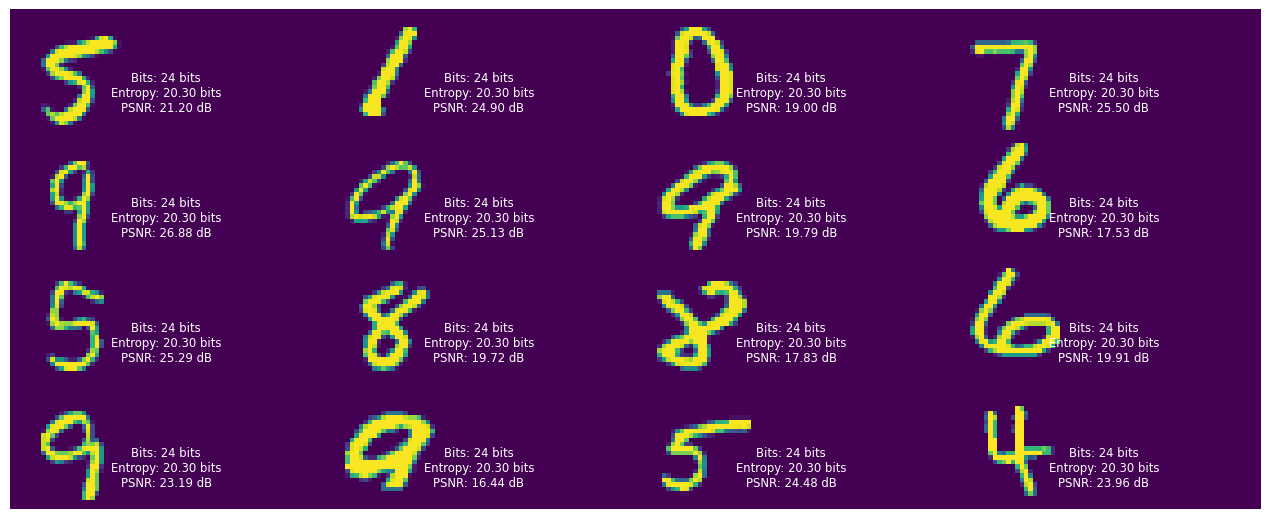

In [ ]:
def display_digits(originals, strings, entropies, reconstructions):
  """Visualizes 16 digits together with their reconstructions."""

  fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(12.5, 5))
  axes = axes.ravel()
  for i in range(len(axes)):

    psnr_value = calculate_psnr(originals[i], reconstructions[i])

    #0x{strings[i].numpy().hex()}
    hex_string = strings[i].numpy().hex()
    nombres_bits = len(hex_string) * 4

    image = tf.concat([
      tf.squeeze(originals[i]),
      tf.zeros((28, 14), tf.uint8),
      tf.squeeze(reconstructions[i]),
    ], 1)
    axes[i].imshow(image)
    axes[i].text(
      .5, .5,
      #f" {nombres_bits} bits \n{entropies[i]:0.2f} bits \n {psnr_value}dB",
      f"Bits: {nombres_bits} bits\n"
      f"Entropy: {entropies[i]:.2f} bits\n"
      f"PSNR: {psnr_value:.2f} dB",

      ha="center", va="top", color="white", fontsize="small",
      transform=axes[i].transAxes)
    axes[i].axis("off")
  plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

display_digits(originals, strings, entropies, reconstructions)

In [ ]:
# Pour tracer la courbe de PSNR en fonction de debits reels

psnrs = []
bitss = []
for i in range(4):
  n = 30

  trainer = train_mnist_model(lmbda= (i+1)*500)
  compressor, decompressor = make_mnist_codec(trainer)
  (originals, _), = validation_dataset.batch(n).skip(3).take(1)
  strings, entropies = compressor(originals)
  reconstructions = decompressor(strings)

  psnr_value = 0
  bits_reels = 0
  for j in range(n):
    psnr_value += calculate_psnr(originals[j], reconstructions[j])
    hex_string = strings[j].numpy().hex()
    bits_reels += len(hex_string) * 4

  psnrs.append(psnr_value / n)
  bitss.append(bits_reels / n)

plt.plot(bitss, psnrs, marker='o')  # marker='o'
#plt.scatter(bitss, psnrs)

plt.title('PSNR vs Bits')
plt.xlabel('Bits')
plt.ylabel('PSNR (dB)')

plt.show()


469/469 [==============================] - ETA: 0s - loss: 127.9606 - distortion_loss: 0.0709 - rate_loss: 92.5245 - distortion_pass_through_loss: 0.0709 - rate_pass_through_loss: 92.5180

469/469 [==============================] - ETA: 0s - loss: 161.7469 - distortion_loss: 0.0666 - rate_loss: 95.1937 - distortion_pass_through_loss: 0.0665 - rate_pass_through_loss: 95.1882

469/469 [==============================] - ETA: 0s - loss: 191.1630 - distortion_loss: 0.0622 - rate_loss: 97.7953 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 97.7907

469/469 [==============================] - ETA: 0s - loss: 191.1630 - distortion_loss: 0.0622 - rate_loss: 97.7953 - distortion_pass_through_loss: 0.0622 - rate_pass_through_loss: 97.7907

355/469 [=====================>........] - ETA: 16s - loss: 230.7596 - distortion_loss: 0.0646 - rate_loss: 101.6315 - distortion_pass_through_loss: 0.0646 - rate_pass_through_loss: 101.6315

In [ ]:
psnrs = []
bitss = []

n = 30

trainer = train_mnist_model(lmbda= 500)
compressor, decompressor = make_mnist_codec(trainer)
(originals, _), = validation_dataset.batch(n).skip(3).take(1)
strings, entropies = compressor(originals)
reconstructions = decompressor(strings)

psnr_value = 0
bits_reels = 0
for j in range(n):
  psnr_value += calculate_psnr(originals[j], reconstructions[j])
  hex_string = strings[j].numpy().hex()
  bits_reels += len(hex_string) * 4

psnrs.append(psnr_value / n)
bitss.append(bits_reels / n)


Epoch 1/5
469/469 [==============================] - ETA: 0s - loss: 127.8904 - distortion_loss: 0.0709 - rate_loss: 92.4397 - distortion_pass_through_loss: 0.0709 - rate_pass_through_loss: 92.4334

469/469 [==============================] - 71s 146ms/step - loss: 127.8904 - distortion_loss: 0.0709 - rate_loss: 92.4397 - distortion_pass_through_loss: 0.0709 - rate_pass_through_loss: 92.4334 - val_loss: 107.1923 - val_distortion_loss: 0.0559 - val_rate_loss: 79.2605 - val_distortion_pass_through_loss: 0.0559 - val_rate_pass_through_loss: 79.2604
Epoch 2/5
469/469 [==============================] - 64s 136ms/step - loss: 97.2141 - distortion_loss: 0.0540 - rate_loss: 70.2314 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 70.2260 - val_loss: 86.1605 - val_distortion_loss: 0.0604 - val_rate_loss: 55.9553 - val_distortion_pass_through_loss: 0.0604 - val_rate_pass_through_loss: 55.9507
Epoch 3/5
469/469 [==============================] - 65s 140ms/step - loss: 81.2971 - distortion_loss: 0.0564 - rate_loss: 53.0971 - distortion_pass_through_loss: 0.0564 - rate_pass_through_loss: 53.0932 - val_loss: 72.0850 - val_distortion_loss: 0.0696 - val_rate_loss: 37.2918 - val_dis

In [ ]:
n = 30

trainer = train_mnist_model(lmbda= 1000)
compressor, decompressor = make_mnist_codec(trainer)
(originals, _), = validation_dataset.batch(n).skip(3).take(1)
strings, entropies = compressor(originals)
reconstructions = decompressor(strings)

psnr_value = 0
bits_reels = 0
for j in range(n):
  psnr_value += calculate_psnr(originals[j], reconstructions[j])
  hex_string = strings[j].numpy().hex()
  bits_reels += len(hex_string) * 4

psnrs.append(psnr_value / n)
bitss.append(bits_reels / n)

Epoch 1/5
469/469 [==============================] - ETA: 0s - loss: 160.0724 - distortion_loss: 0.0647 - rate_loss: 95.3939 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 95.3884

469/469 [==============================] - 71s 147ms/step - loss: 160.0724 - distortion_loss: 0.0647 - rate_loss: 95.3939 - distortion_pass_through_loss: 0.0647 - rate_pass_through_loss: 95.3884 - val_loss: 132.4959 - val_distortion_loss: 0.0476 - val_rate_loss: 84.9374 - val_distortion_pass_through_loss: 0.0476 - val_rate_pass_through_loss: 84.9394
Epoch 2/5
469/469 [==============================] - 65s 138ms/step - loss: 122.1053 - distortion_loss: 0.0465 - rate_loss: 75.6234 - distortion_pass_through_loss: 0.0465 - rate_pass_through_loss: 75.6181 - val_loss: 112.0526 - val_distortion_loss: 0.0479 - val_rate_loss: 64.1590 - val_distortion_pass_through_loss: 0.0479 - val_rate_pass_through_loss: 64.1643
Epoch 3/5
469/469 [==============================] - 64s 137ms/step - loss: 107.1197 - distortion_loss: 0.0468 - rate_loss: 60.2901 - distortion_pass_through_loss: 0.0468 - rate_pass_through_loss: 60.2867 - val_loss: 99.9448 - val_distortion_loss: 0.0511 - val_rate_loss: 48.8883 - val_

In [ ]:
n = 30

trainer = train_mnist_model(lmbda= 1500)
compressor, decompressor = make_mnist_codec(trainer)
(originals, _), = validation_dataset.batch(n).skip(3).take(1)
strings, entropies = compressor(originals)
reconstructions = decompressor(strings)

psnr_value = 0
bits_reels = 0
for j in range(n):
  psnr_value += calculate_psnr(originals[j], reconstructions[j])
  hex_string = strings[j].numpy().hex()
  bits_reels += len(hex_string) * 4

psnrs.append(psnr_value / n)
bitss.append(bits_reels / n)

NameError: name 'make_mnist_compression_trainer' is not defined

Epoch 1/5
469/469 [==============================] - ETA: 0s - loss: 218.3499 - distortion_loss: 0.0591 - rate_loss: 100.0607 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 100.0561

469/469 [==============================] - 71s 146ms/step - loss: 218.3499 - distortion_loss: 0.0591 - rate_loss: 100.0607 - distortion_pass_through_loss: 0.0591 - rate_pass_through_loss: 100.0561 - val_loss: 177.4526 - val_distortion_loss: 0.0430 - val_rate_loss: 91.5337 - val_distortion_pass_through_loss: 0.0430 - val_rate_pass_through_loss: 91.5375
Epoch 2/5
469/469 [==============================] - 65s 138ms/step - loss: 166.6915 - distortion_loss: 0.0414 - rate_loss: 83.8777 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 83.8734 - val_loss: 156.2136 - val_distortion_loss: 0.0403 - val_rate_loss: 75.6819 - val_distortion_pass_through_loss: 0.0403 - val_rate_pass_through_loss: 75.6965
Epoch 3/5
469/469 [==============================] - 65s 139ms/step - loss: 151.5462 - distortion_loss: 0.0403 - rate_loss: 70.9888 - distortion_pass_through_loss: 0.0403 - rate_pass_through_loss: 70.9858 - val_loss: 144.8214 - val_distortion_loss: 0.0409 - val_rate_loss: 63.0680 - v

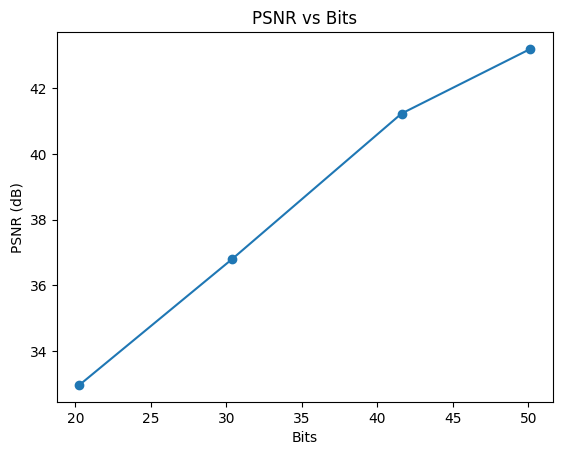

In [ ]:
n = 30

trainer = train_mnist_model(lmbda= 2000)
compressor, decompressor = make_mnist_codec(trainer)
(originals, _), = validation_dataset.batch(n).skip(3).take(1)
strings, entropies = compressor(originals)
reconstructions = decompressor(strings)

psnr_value = 0
bits_reels = 0
for j in range(n):
  psnr_value += calculate_psnr(originals[j], reconstructions[j])
  hex_string = strings[j].numpy().hex()
  bits_reels += len(hex_string) * 4

psnrs.append(psnr_value / n)
bitss.append(bits_reels / n)

plt.plot(bitss, psnrs, marker='o')  # marker='o'
#plt.scatter(bitss, psnrs)

plt.title('PSNR vs Bits')
plt.xlabel('Bits')
plt.ylabel('PSNR (dB)')

plt.show()

In [ ]:
def train_and_visualize_model(lmbda):
  trainer = train_mnist_model(lmbda=lmbda)
  compressor, decompressor = make_mnist_codec(trainer)
  strings, entropies = compressor(originals)
  reconstructions = decompressor(strings)
  display_digits(originals, strings, entropies, reconstructions)

Epoch 1/3
469/469 [==============================] - ETA: 0s - loss: 127.3827 - distortion_loss: 0.0696 - rate_loss: 92.5662 - distortion_pass_through_loss: 0.0696 - rate_pass_through_loss: 92.5600

469/469 [==============================] - 112s 229ms/step - loss: 127.3827 - distortion_loss: 0.0696 - rate_loss: 92.5662 - distortion_pass_through_loss: 0.0696 - rate_pass_through_loss: 92.5600 - val_loss: 107.1820 - val_distortion_loss: 0.0543 - val_rate_loss: 80.0404 - val_distortion_pass_through_loss: 0.0543 - val_rate_pass_through_loss: 80.0427
Epoch 2/3
469/469 [==============================] - 99s 211ms/step - loss: 97.1795 - distortion_loss: 0.0540 - rate_loss: 70.2037 - distortion_pass_through_loss: 0.0540 - rate_pass_through_loss: 70.1983 - val_loss: 86.4610 - val_distortion_loss: 0.0610 - val_rate_loss: 55.9669 - val_distortion_pass_through_loss: 0.0609 - val_rate_pass_through_loss: 55.9722
Epoch 3/3
469/469 [==============================] - 102s 218ms/step - loss: 81.1686 - distortion_loss: 0.0563 - rate_loss: 53.0403 - distortion_pass_through_loss: 0.0563 - rate_pass_through_loss: 53.0365 - val_loss: 72.0708 - val_distortion_loss: 0.0696 - val_rate_loss: 37.2614 - val_d

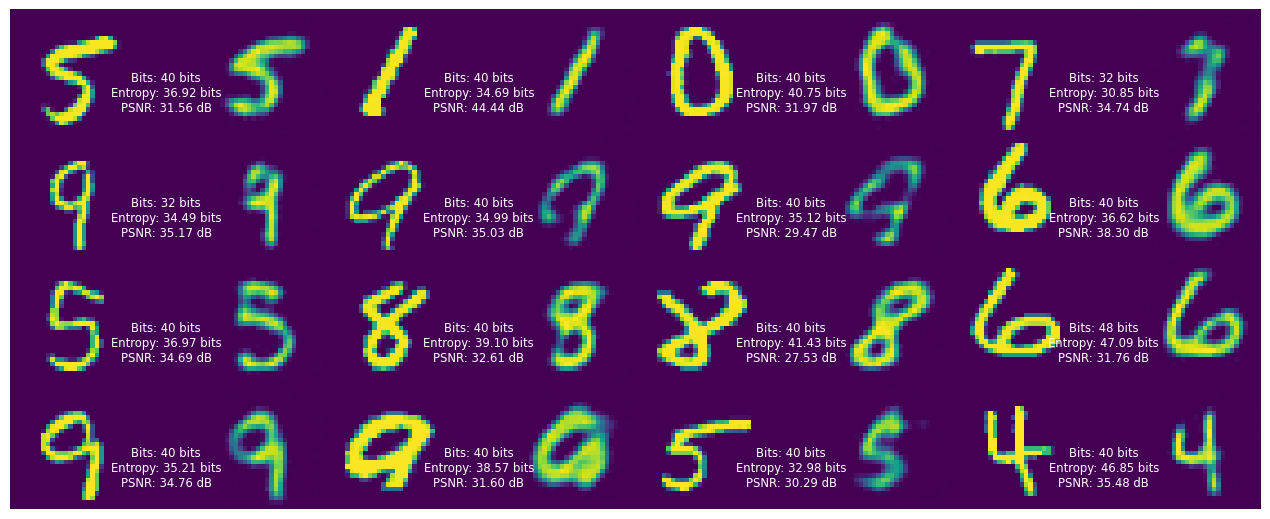

In [ ]:
train_and_visualize_model(lmbda=500)

Epoch 1/3
469/469 [==============================] - ETA: 0s - loss: 113.6418 - distortion_loss: 0.0753 - rate_loss: 91.0668 - distortion_pass_through_loss: 0.0752 - rate_pass_through_loss: 91.0600

469/469 [==============================] - 123s 257ms/step - loss: 113.6418 - distortion_loss: 0.0753 - rate_loss: 91.0668 - distortion_pass_through_loss: 0.0752 - rate_pass_through_loss: 91.0600 - val_loss: 96.4353 - val_distortion_loss: 0.0676 - val_rate_loss: 76.1612 - val_distortion_pass_through_loss: 0.0676 - val_rate_pass_through_loss: 76.1612
Epoch 2/3
469/469 [==============================] - 97s 207ms/step - loss: 85.7254 - distortion_loss: 0.0606 - rate_loss: 67.5493 - distortion_pass_through_loss: 0.0606 - rate_pass_through_loss: 67.5438 - val_loss: 74.1355 - val_distortion_loss: 0.0773 - val_rate_loss: 50.9434 - val_distortion_pass_through_loss: 0.0773 - val_rate_pass_through_loss: 50.9542
Epoch 3/3
469/469 [==============================] - 93s 198ms/step - loss: 68.7676 - distortion_loss: 0.0643 - rate_loss: 49.4811 - distortion_pass_through_loss: 0.0643 - rate_pass_through_loss: 49.4772 - val_loss: 58.4789 - val_distortion_loss: 0.0900 - val_rate_loss: 31.4844 - val_dis

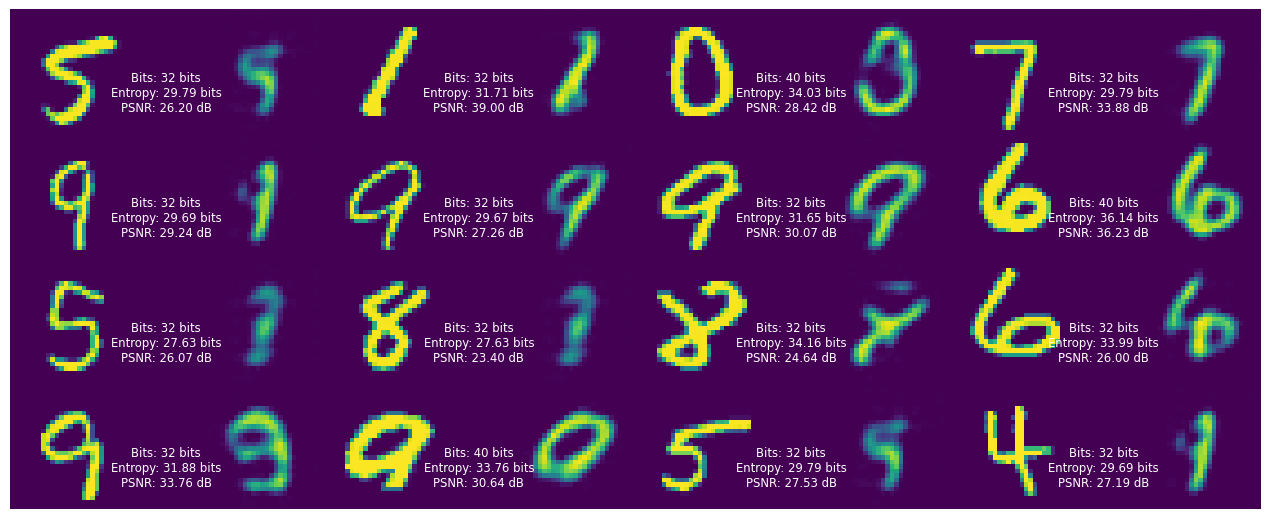

In [ ]:
train_and_visualize_model(lmbda=300)

In [ ]:
compressor, decompressor = make_mnist_codec(trainer, decode_sanity_check=False)

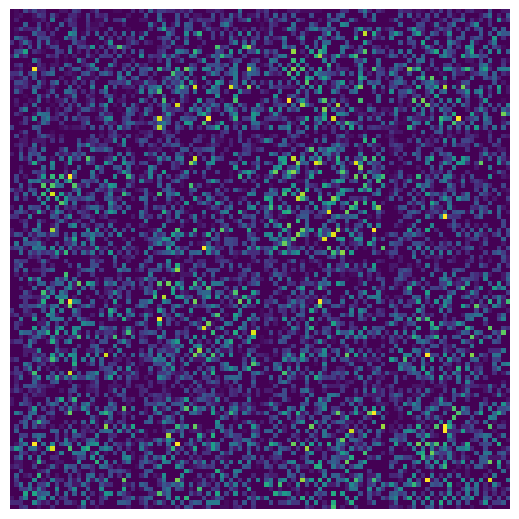

In [ ]:
import os

strings = tf.constant([os.urandom(8) for _ in range(16)])
samples = decompressor(strings)

fig, axes = plt.subplots(4, 4, sharex=True, sharey=True, figsize=(5, 5))
axes = axes.ravel()
for i in range(len(axes)):
  axes[i].imshow(tf.squeeze(samples[i]))
  axes[i].axis("off")

plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)

Epoch 1/3
469/469 [==============================] - ETA: 0s - loss: 254.9915 - distortion_loss: 0.0599 - rate_loss: 135.1699 - distortion_pass_through_loss: 0.0599 - rate_pass_through_loss: 135.1624

469/469 [==============================] - 91s 189ms/step - loss: 254.9915 - distortion_loss: 0.0599 - rate_loss: 135.1699 - distortion_pass_through_loss: 0.0599 - rate_pass_through_loss: 135.1624 - val_loss: 206.8287 - val_distortion_loss: 0.0425 - val_rate_loss: 121.8714 - val_distortion_pass_through_loss: 0.0425 - val_rate_pass_through_loss: 121.8761
Epoch 2/3
469/469 [==============================] - 86s 184ms/step - loss: 191.2530 - distortion_loss: 0.0411 - rate_loss: 108.9627 - distortion_pass_through_loss: 0.0411 - rate_pass_through_loss: 108.9561 - val_loss: 176.7430 - val_distortion_loss: 0.0410 - val_rate_loss: 94.8223 - val_distortion_pass_through_loss: 0.0410 - val_rate_pass_through_loss: 94.8254
Epoch 3/3
469/469 [==============================] - 84s 179ms/step - loss: 169.2302 - distortion_loss: 0.0404 - rate_loss: 88.3559 - distortion_pass_through_loss: 0.0404 - rate_pass_through_loss: 88.3511 - val_loss: 158.8896 - val_distortion_loss: 0.0427 - val_rate_loss: 73.4973

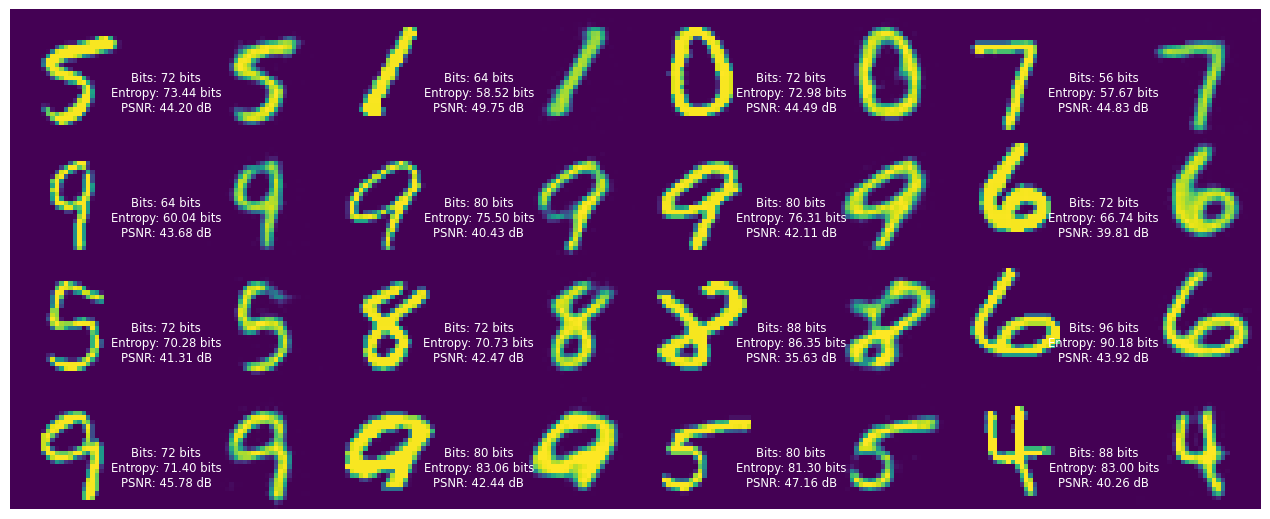

In [ ]:
train_and_visualize_model(lmbda=2000)

Epoch 1/3
469/469 [==============================] - ETA: 0s - loss: 217.3254 - distortion_loss: 0.0586 - rate_loss: 100.1310 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 100.1264

469/469 [==============================] - 104s 206ms/step - loss: 217.3254 - distortion_loss: 0.0586 - rate_loss: 100.1310 - distortion_pass_through_loss: 0.0586 - rate_pass_through_loss: 100.1264 - val_loss: 177.9812 - val_distortion_loss: 0.0430 - val_rate_loss: 91.9385 - val_distortion_pass_through_loss: 0.0430 - val_rate_pass_through_loss: 91.9393
Epoch 2/3
469/469 [==============================] - 95s 202ms/step - loss: 166.8699 - distortion_loss: 0.0414 - rate_loss: 84.0635 - distortion_pass_through_loss: 0.0414 - rate_pass_through_loss: 84.0590 - val_loss: 156.8679 - val_distortion_loss: 0.0406 - val_rate_loss: 75.7663 - val_distortion_pass_through_loss: 0.0405 - val_rate_pass_through_loss: 75.7710
Epoch 3/3
469/469 [==============================] - 95s 204ms/step - loss: 151.2251 - distortion_loss: 0.0400 - rate_loss: 71.1252 - distortion_pass_through_loss: 0.0400 - rate_pass_through_loss: 71.1223 - val_loss: 144.4123 - val_distortion_loss: 0.0401 - val_rate_loss: 64.1284 - 

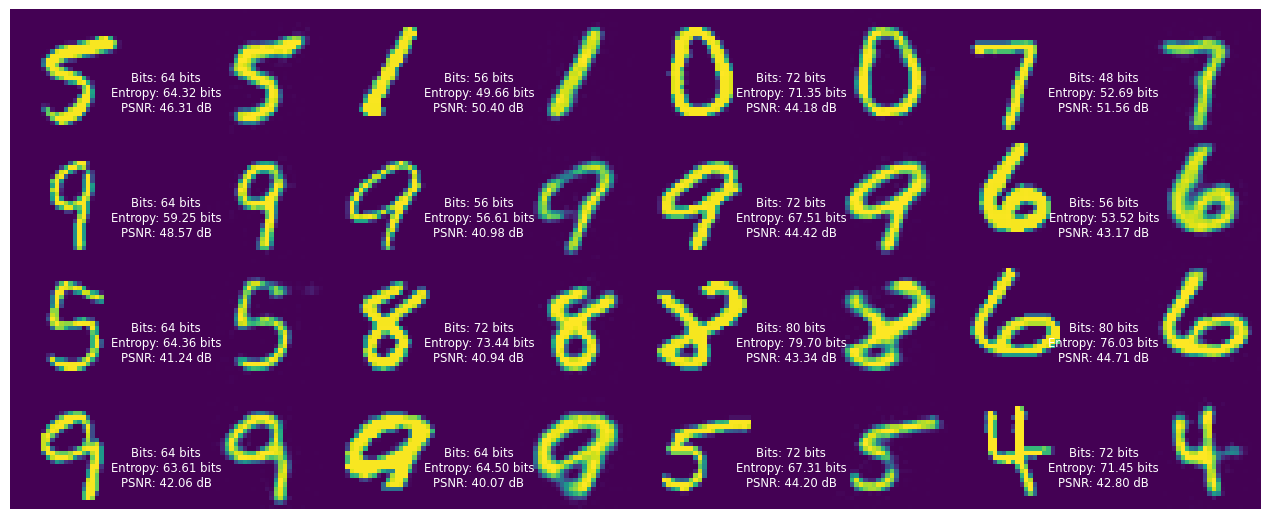

In [ ]:
train_and_visualize_model(lmbda=2000)